_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Max Bardelang, Sascha Mühlinghaus

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 2

## Introduction

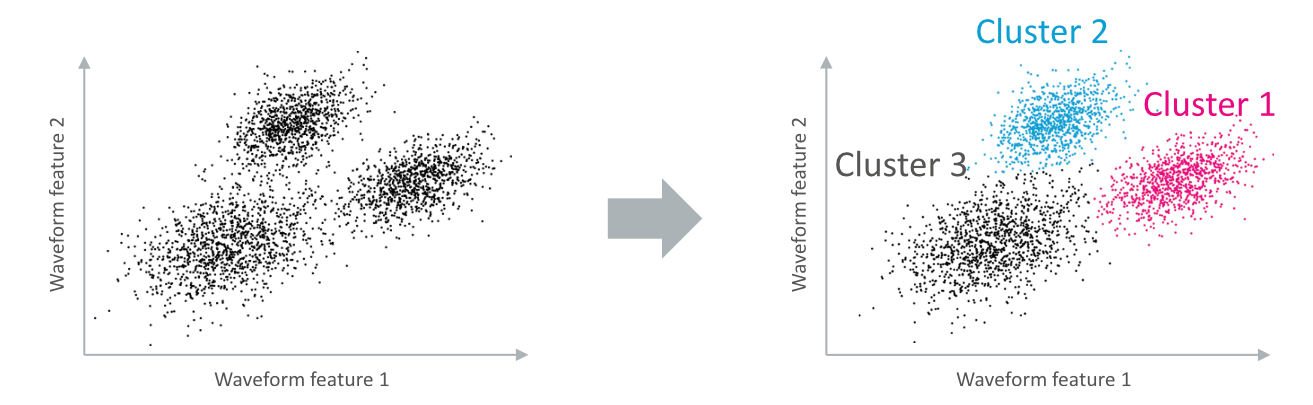

In this coding lab, we continue with the x from the first coding lab and finalize the Spike Sorting pipeline.
In particular, we use the created feature space to identify individual clusters by fitting a Gaussian Mixture Model.
To verify that this model does what we want, we first create a synthetic Toy Dataset and apply the model to that.

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [60]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-03 12:00:01CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

sklearn: 1.6.1

sklearn   : 1.6.1
matplotlib: 3.10.1
numpy     : 2.2.5
scipy     : 1.15.2

Watermark: 2.5.0



In [61]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [62]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
t = np.load("../data/nds_cl_1_spiketimes_t.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")

FileNotFoundError: [Errno 2] No such file or directory: '../data/nds_cl_1_features.npy'

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 2 pts*


In [ ]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (1 pt)
    # ------------------------------------------------------

    # sample cluster labels
    labels = rng.choice(len(p), size=n_samples, p=p)
    # create variable data points
    x = np.empty((n_samples, m.shape[1]))
    for i in range(len(p)):
        # sample points from the corresponding cluster
        x[labels == i] = rng.multivariate_normal(m[i], S[i], size=(labels == i).sum())

    return labels, x

In [63]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

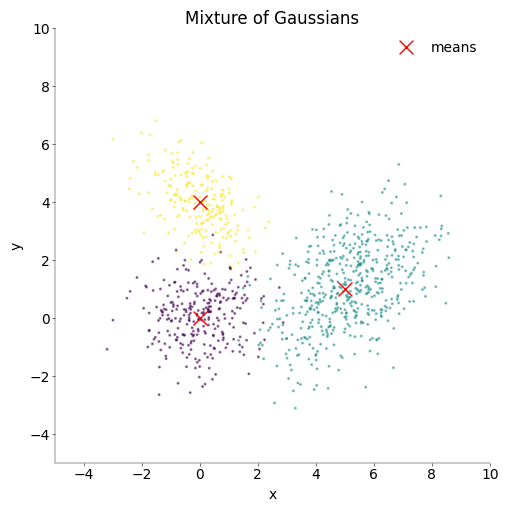

In [64]:
# ----------------------------------------------
# plot points from mixture of Gaussians (1 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
ax.set_title("Mixture of Gaussians")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.set_aspect("equal")
ax.scatter(x[:, 0], x[:, 1], c=labels, s=5, cmap="viridis", alpha=0.5)
ax.scatter(m[:, 0], m[:, 1], c="red", s=100, marker="x", label="means")
ax.legend()
plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 6 pts*


In [65]:
from scipy.stats import multivariate_normal


def fit_mog(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------
    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed

    Returns
    -------
    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """
    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # -----------
    # init (1 pt)
    # -----------

    # set tolerance and convergence limit
    tol = 1e-6
    # get data dimensions
    n_samples, n_dims = x.shape
    # initialize cluster assignments randomly
    if init == "random":
        cluster_ids = rng.integers(0, n_clusters, size=n_samples)
    # initialize cluster assignments with k-means
    if init == "kmeans":
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed)
        kmeans.fit(x)
        cluster_ids = kmeans.labels_
    # initialize cluster means, covariances and priors
    m = np.array(
        [
            (
                np.mean(x[cluster_ids == i], axis=0)
                if np.any(cluster_ids == i)
                else rng.normal(size=n_dims)
            )
            for i in range(n_clusters)
        ]
    )
    S = np.array(
        [
            (
                np.cov(x[cluster_ids == i].T) + tol * np.eye(n_dims)
                if np.any(cluster_ids == i)
                else np.eye(n_dims)
            )
            for i in range(n_clusters)
        ]
    )
    p = np.array([np.sum(cluster_ids == i) / n_samples for i in range(n_clusters)])
    # initialize log-likelihood
    LLs = [-np.inf]

    # -------------------------
    # EM maximisation (3 pts)
    # -------------------------

    for step in range(n_iters):
        # E step
        # Evaluate the posterior probablibities `r`
        # using the current values of `m` and `S`
        responsibilities = np.zeros((n_clusters, n_samples))
        for k in range(n_clusters):
            responsibilities[k] = p[k] * multivariate_normal.pdf(x, mean=m[k], cov=S[k])

        weighted_likelihoods = responsibilities.copy()  # store before normalization
        responsibilities /= np.sum(responsibilities, axis=0)

        # update cluster assignments
        cluster_ids = np.argmax(responsibilities, axis=0)

        # M step
        # Estimate new `m`, `S` and `p`
        # update means and add weight
        m = np.zeros((n_clusters, n_dims))
        for i in range(n_clusters):
            weights = responsibilities[i]
            total_weight = np.sum(weights)
            m[i] = np.sum(weights[:, None] * x, axis=0) / total_weight

        # update covariances and add weight
        S = np.zeros((n_clusters, n_dims, n_dims))
        for i in range(n_clusters):
            diff = x - m[i]
            weights = responsibilities[i]
            S[i] = (weights[:, None, None] * np.einsum("ni,nj->nij", diff, diff)).sum(
                axis=0
            )
            S[i] /= np.sum(weights)
            S[i] += tol * np.eye(n_dims)

        # update priors
        p = np.sum(responsibilities, axis=1)
        p /= n_samples

        # corrected log-likelihood computation
        LL = np.sum(np.log(np.sum(weighted_likelihoods, axis=0)))

        # print log-likelihood
        print(f"Iteration {step+1}: Log Likelihood = {LL:.6f}")

        # check for convergence
        if np.abs(LL - LLs[-1]) < tol:
            break

        # append log-likelihood
        LLs.append(LL)

    # assign cluster labels
    cluster_ids = np.argmax(responsibilities, axis=0)

    return (cluster_ids, m, S, p)

Run Mixture of Gaussian on toy data

Iteration 1: Log Likelihood = -4492.977557
Iteration 2: Log Likelihood = -4489.528084
Iteration 3: Log Likelihood = -4482.077649
Iteration 4: Log Likelihood = -4466.211616
Iteration 5: Log Likelihood = -4439.554350
Iteration 6: Log Likelihood = -4410.354902
Iteration 7: Log Likelihood = -4390.349393
Iteration 8: Log Likelihood = -4377.630456
Iteration 9: Log Likelihood = -4365.709153
Iteration 10: Log Likelihood = -4350.427361
Iteration 1: Log Likelihood = -4076.596995
Iteration 2: Log Likelihood = -4067.268413
Iteration 3: Log Likelihood = -4063.112120
Iteration 4: Log Likelihood = -4060.686755
Iteration 5: Log Likelihood = -4059.404670
Iteration 6: Log Likelihood = -4058.772807
Iteration 7: Log Likelihood = -4058.473723
Iteration 8: Log Likelihood = -4058.335581
Iteration 9: Log Likelihood = -4058.272742
Iteration 10: Log Likelihood = -4058.244428
Iteration 1: Log Likelihood = -4494.390291
Iteration 2: Log Likelihood = -4493.895983
Iteration 3: Log Likelihood = -4493.343514
Iteration

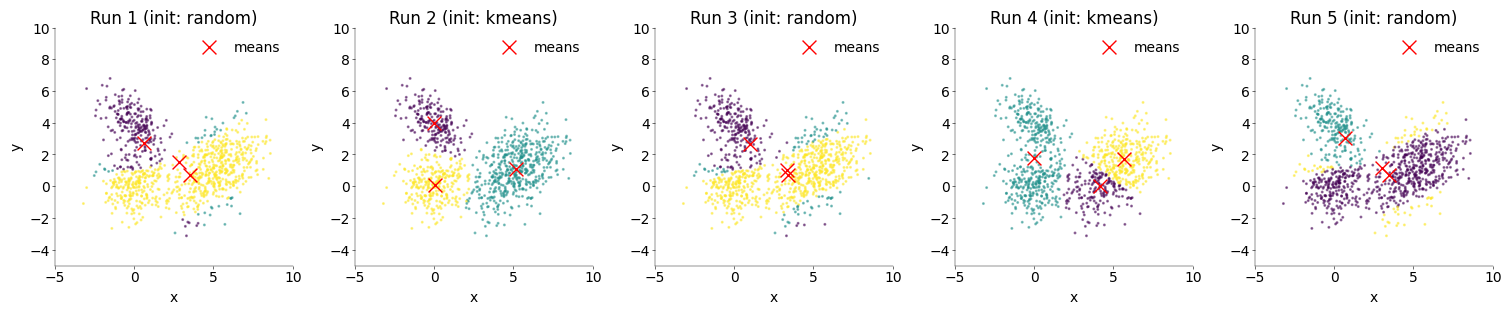

In [66]:
# -------------------------------------------------------------------------
# Run the algorithm 5 times on the toy data, plot and compare original and
# assigned clusters and answer the questions (1+1 pts)
# -------------------------------------------------------------------------

# initialize parameters
n_clusters = 3
n_iters = 10
random_seed = 0
n_runs = 5
labels_list = []
means_list = []
covs_list = []
priors_list = []
init = "random"
init_list = []
# run gmm 5 times
for i in range(n_runs):
    labels, means, covs, priors = fit_mog(x, n_clusters, n_iters, random_seed + i, init)
    labels_list.append(labels)
    means_list.append(means)
    covs_list.append(covs)
    priors_list.append(priors)
    init_list.append(init)
    # alternate between random and kmeans initialization
    init = "random" if init == "kmeans" else "kmeans"
# plot the results
fig, axs = plt.subplots(1, n_runs, figsize=(15, 5), layout="constrained")
for i in range(n_runs):
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    axs[i].set_xlim(-5, 10)
    axs[i].set_ylim(-5, 10)
    axs[i].set_aspect("equal")
    axs[i].scatter(x[:, 0], x[:, 1], c=labels_list[i], s=5, cmap="viridis", alpha=0.5)
    axs[i].scatter(
        means_list[i][:, 0],
        means_list[i][:, 1],
        c="red",
        s=100,
        marker="x",
        label="means",
    )
    axs[i].legend()
    axs[i].set_title(f"Run {i+1} (init: {init_list[i]})")
plt.show()

### Questions

1) Do all runs converge to good solutions? If not, which one would you pick (only visual inspection required) as the best one?
 
No, not all runs converge to optimal solutions. Only the second run finds a nearly optimal solution. 

2) Do you get the same colors (=labels) in your best assignment(s) compared to the groundtruth? Does it have to be that way or not? Why?

No, I do not always get the same color assignments and it does also not matter which color each cluster has, as long as the clusters match the different gaussian distributions from the data sampling.

## Bonus Task (Optional): Mixture of drifting t-distributions

Instead of a simple Gaussian Mixture Model, more advanced algorithms can be implemented.
Implement a basic version of the mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf).
What is the advantage of that method?

_Grading: 2 BONUS Points._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [67]:
from scipy.stats import multivariate_t


def fit_mot(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    df: float = 5.0,  # degrees of freedom for t-distribution
    drift_scale: float = 0.01,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit a Mixture of Drifting t-Distributions using EM-like algorithm."""

    rng = np.random.default_rng(random_seed)
    tol = 1e-6
    n_samples, n_dims = x.shape

    # --- Initialization ---
    if init == "random":
        cluster_ids = rng.integers(0, n_clusters, size=n_samples)
    elif init == "kmeans":
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(x)
        cluster_ids = kmeans.labels_

    m = np.array(
        [
            (
                np.mean(x[cluster_ids == i], axis=0)
                if np.any(cluster_ids == i)
                else rng.normal(size=n_dims)
            )
            for i in range(n_clusters)
        ]
    )

    S = np.array(
        [
            (
                np.cov(x[cluster_ids == i].T) + tol * np.eye(n_dims)
                if np.any(cluster_ids == i)
                else np.eye(n_dims)
            )
            for i in range(n_clusters)
        ]
    )

    p = np.array([np.sum(cluster_ids == i) / n_samples for i in range(n_clusters)])
    LLs = [-np.inf]

    for step in range(n_iters):
        # --- Drift Step (approximate drift with Kalman filter update) ---
        m += rng.normal(scale=drift_scale, size=m.shape)

        # --- E-Step ---
        responsibilities = np.zeros((n_clusters, n_samples))
        for k in range(n_clusters):
            rv = multivariate_t(loc=m[k], shape=S[k], df=df)
            responsibilities[k] = p[k] * rv.pdf(x)

        weighted_likelihoods = responsibilities.copy()
        responsibilities /= np.sum(responsibilities, axis=0) + 1e-12
        cluster_ids = np.argmax(responsibilities, axis=0)

        # --- M-Step ---
        for k in range(n_clusters):
            weights = responsibilities[k]
            total_weight = np.sum(weights)

            # update mean
            m[k] = np.sum(weights[:, None] * x, axis=0) / total_weight

            # update robust and drifiting covariance
            diff = x - m[k]
            S[k] = (weights[:, None, None] * np.einsum("ni,nj->nij", diff, diff)).sum(
                axis=0
            )
            S[k] /= total_weight
            S[k] += tol * np.eye(n_dims)

        # update priors
        p = np.sum(responsibilities, axis=1)
        p /= n_samples

        # log-likelihood
        LL = np.sum(np.log(np.sum(weighted_likelihoods, axis=0) + 1e-12))
        print(f"Iteration {step+1}: Log Likelihood = {LL:.6f}")

        if np.abs(LL - LLs[-1]) < tol:
            break
        LLs.append(LL)

    cluster_ids = np.argmax(responsibilities, axis=0)
    return cluster_ids, m, S, p

Iteration 1: Log Likelihood = -4143.774447
Iteration 2: Log Likelihood = -4165.198643
Iteration 3: Log Likelihood = -4180.076363
Iteration 4: Log Likelihood = -4191.332949
Iteration 5: Log Likelihood = -4199.699812
Iteration 6: Log Likelihood = -4202.543766
Iteration 7: Log Likelihood = -4204.348207
Iteration 8: Log Likelihood = -4207.615169
Iteration 9: Log Likelihood = -4211.175451
Iteration 10: Log Likelihood = -4211.942052
Iteration 11: Log Likelihood = -4210.606429
Iteration 12: Log Likelihood = -4212.992952
Iteration 13: Log Likelihood = -4212.961772
Iteration 14: Log Likelihood = -4214.827191
Iteration 15: Log Likelihood = -4214.864026
Iteration 16: Log Likelihood = -4215.836968
Iteration 17: Log Likelihood = -4217.252210
Iteration 18: Log Likelihood = -4214.962110
Iteration 19: Log Likelihood = -4212.605551
Iteration 20: Log Likelihood = -4212.073768


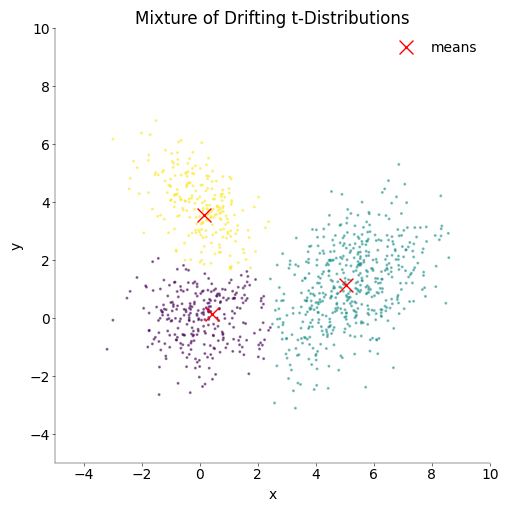

In [68]:
labels, means, covs, weights = fit_mot(
    x, n_clusters=3, n_iters=20, df=4, drift_scale=0.05, init="kmeans"
)

# Plot the results
fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
ax.set_title("Mixture of Drifting t-Distributions")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.set_aspect("equal")
ax.scatter(x[:, 0], x[:, 1], c=labels, s=5, cmap="viridis", alpha=0.5)
ax.scatter(
    means[:, 0],
    means[:, 1],
    c="red",
    s=100,
    marker="x",
    label="means",
)
ax.legend()
plt.show()

1) What is the advantage of the drifting t-distribution?

By modelling the drift of the distributions according to a Kalman filter update, we can approximate movements of the recording electrodes. Hence, possible changes in the recordings due to movement are being addressed and are accounted for. Because of the drift the LL may also increase at times, therefore, the EM-algorithm is not strictly converging anymore.

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 5 pts*



### Question (0.5 pts)

1) What is the number of parameters of the model?

Let:
- `K`: Number of Gaussian components
- `D`: Dimensionality of the data

#### For **full covariance**:

```
Total = K * [ D + D(D+1)/2 ] + (K - 1)
```

#### For **diagonal covariance**:

```
Total = K * (2D) + (K - 1)
```

#### For **spherical covariance**:

```
Total = K * (D + 1) + (K - 1)
```

In [23]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    # compute the log-likelihood
    from scipy.stats import multivariate_normal

    n_samples = x.shape[0]
    K = m.shape[0]

    # compute the log-likelihood
    log_likelihood = 0
    for i in range(n_samples):
        mixture_sum = 0
        for k in range(K):
            mixture_sum += p[k] * multivariate_normal.pdf(x[i], mean=m[k], cov=S[k])
        log_likelihood += np.log(mixture_sum)
    LL = log_likelihood
    # compute number of parameters for GMM
    n_params = m.size + S.size + p.size
    # compute the BIC
    bic = -2 * LL + n_params * np.log(x.shape[0])

    return bic, LL

Iteration 1: Log Likelihood = -4165.460035
Iteration 2: Log Likelihood = -4163.438116
Iteration 3: Log Likelihood = -4162.875462
Iteration 4: Log Likelihood = -4162.678959
Iteration 5: Log Likelihood = -4162.610473
Iteration 6: Log Likelihood = -4162.586621
Iteration 7: Log Likelihood = -4162.578302
Iteration 8: Log Likelihood = -4162.575397
Iteration 9: Log Likelihood = -4162.574381
Iteration 10: Log Likelihood = -4162.574025
Iteration 1: Log Likelihood = -4165.185497
Iteration 2: Log Likelihood = -4163.328505
Iteration 3: Log Likelihood = -4162.836625
Iteration 4: Log Likelihood = -4162.665415
Iteration 5: Log Likelihood = -4162.605758
Iteration 6: Log Likelihood = -4162.584978
Iteration 7: Log Likelihood = -4162.577728
Iteration 8: Log Likelihood = -4162.575196
Iteration 9: Log Likelihood = -4162.574311
Iteration 10: Log Likelihood = -4162.574001
Iteration 1: Log Likelihood = -4165.460035
Iteration 2: Log Likelihood = -4163.438116
Iteration 3: Log Likelihood = -4162.875462
Iteration

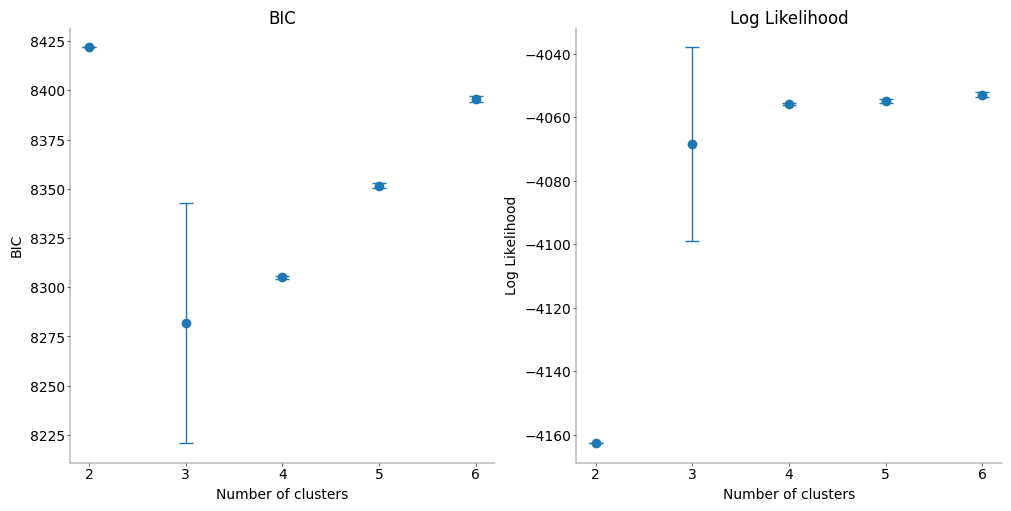

In [50]:
# ----------------------------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your _estimate of the BIC_ robust against local minima, regardless of the initialization strategy used (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

K = np.arange(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
for i, k in enumerate(K):
    for j in range(num_seeds):
        labels, means, covs, priors = fit_mog(x, k, n_iters, random_seed + j, "kmeans")
        BIC[j, i], LL[j, i] = mog_bic(x, means, covs, priors)
# compute the mean and std of BIC
BIC_mean = np.mean(BIC, axis=0)
BIC_std = np.std(BIC, axis=0)
# compute the mean and std of LL
LL_mean = np.mean(LL, axis=0)
LL_std = np.std(LL, axis=0)
# make subplot with bic and ll
fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
axs[0].set_title("BIC")
axs[0].set_xlabel("Number of clusters")
axs[0].set_ylabel("BIC")
axs[0].errorbar(K, BIC_mean, yerr=BIC_std, fmt="o", capsize=5)
axs[0].set_xticks(K)
axs[0].set_xticklabels(K)
axs[1].set_title("Log Likelihood")
axs[1].set_xlabel("Number of clusters")
axs[1].set_ylabel("Log Likelihood")
axs[1].errorbar(K, LL_mean, yerr=LL_std, fmt="o", capsize=5)
axs[1].set_xticks(K)
axs[1].set_xticklabels(K)
plt.show()

In [62]:
def find_k_and_fit(
    x: np.ndarray, n_iters: int = 10, random_seed: int = 0, extended_search: int = 5
) -> tuple[
    int, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, list
]:
    """Find the best number of clusters using BIC and fit the model.

    Parameters
    ----------
    x: np.ndarray, (n_samples, n_dims)
        Input data
    n_iters: int
        Maximal number of iterations.
    random_seed: int
        Random Seed
    extended_search: int
        Number of iterations to continue searching after BIC starts increasing.

    Returns
    -------
    best_k: int
        Best number of clusters
    labels: np.ndarray, (n_samples)
        Cluster labels
    means: np.ndarray, (n_clusters, n_dims)
        Means
    covs: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances
    priors: np.ndarray, (n_clusters, )
        Priors
    best_bic: float
        Best BIC
    best_log_likelihood: float
        Log likelihood of the best model
    all_models: list
        List of dictionaries containing all tested models with their BIC and log-likelihood
    """

    # initialize variables
    best_bic = np.inf
    best_k = None
    best_model = None
    best_ll = None
    all_models = []

    # initialize loop variables
    k = 2
    no_improve_counter = 0

    # keep searching until BIC increases for given times after best value
    while no_improve_counter < extended_search:
        labels, means, covs, priors = fit_mog(x, k, n_iters, random_seed, "kmeans")
        bic, ll = mog_bic(x, means, covs, priors)
        print(f"Number of clusters: {k}, BIC: {bic:.2f}, LL: {ll:.2f}")

        # Store the current model's details in the all_models list
        all_models.append(
            {
                "k": k,
                "bic": bic,
                "ll": ll,
                "labels": labels,
                "means": means,
                "covs": covs,
                "priors": priors,
            }
        )

        if bic < best_bic:
            best_bic = bic
            best_k = k
            best_model = (labels, means, covs, priors)
            best_ll = ll
            no_improve_counter = 0  # reset counter on improvement
        else:
            no_improve_counter += 1  # count how many times we don't improve

        k += 1

    print(f"Best number of clusters: {best_k}")
    labels, means, covs, priors = best_model
    return best_k, labels, means, covs, priors, best_bic, best_ll, all_models

Iteration 1: Log Likelihood = -4165.460035
Iteration 2: Log Likelihood = -4163.438116
Iteration 3: Log Likelihood = -4162.875462
Iteration 4: Log Likelihood = -4162.678959
Iteration 5: Log Likelihood = -4162.610473
Iteration 6: Log Likelihood = -4162.586621
Iteration 7: Log Likelihood = -4162.578302
Iteration 8: Log Likelihood = -4162.575397
Iteration 9: Log Likelihood = -4162.574381
Iteration 10: Log Likelihood = -4162.574025
Number of clusters: 2, BIC: 8421.86, LL: -4162.57
Iteration 1: Log Likelihood = -4079.217364
Iteration 2: Log Likelihood = -4069.527326
Iteration 3: Log Likelihood = -4064.728696
Iteration 4: Log Likelihood = -4061.636366
Iteration 5: Log Likelihood = -4059.899011
Iteration 6: Log Likelihood = -4059.014258
Iteration 7: Log Likelihood = -4058.587544
Iteration 8: Log Likelihood = -4058.388123
Iteration 9: Log Likelihood = -4058.296696
Iteration 10: Log Likelihood = -4058.255273
Number of clusters: 3, BIC: 8261.54, LL: -4058.24
Iteration 1: Log Likelihood = -4076.88

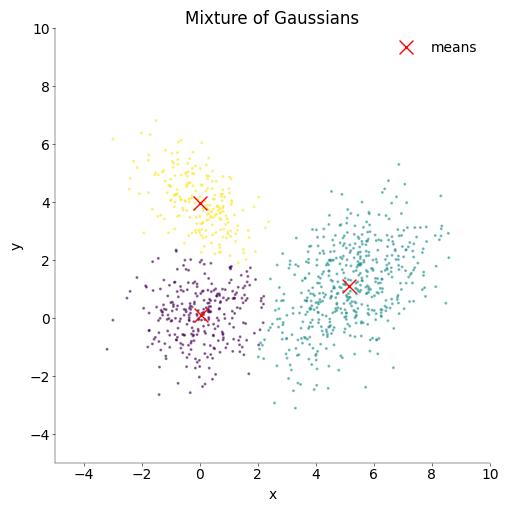

In [63]:
# ------------------------------------------------------------------------------------------
# Plot the result and answer the questions (1+1 pts)
# Don't forget to plot your robust estimate and highlight the estimated number of clusters!
# ------------------------------------------------------------------------------------------

# call function to find the best number of clusters
best_k, labels, means, covs, priors, best_bic, best_ll, all_models = find_k_and_fit(
    x, n_iters=10, random_seed=0, extended_search=5
)

# plot the best model
fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
ax.set_title("Mixture of Gaussians")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
ax.set_aspect("equal")
ax.scatter(x[:, 0], x[:, 1], c=labels, s=5, cmap="viridis", alpha=0.5)
ax.scatter(
    means[:, 0],
    means[:, 1],
    c="red",
    s=100,
    marker="x",
    label="means",
)
ax.legend()
plt.show()

### Questions

1) What happens to the BIC if the model got stuck in a local minimum? For your reasoning, you can also refer to Task 2.

The BIC will be smaller for the current locel minimum number of clusters than the antecendent and successor number of clusters which could lead to a suboptimal termination of the fitting. To counter this, we implemented an algorithm which will keep trying for a few iterations before terminating.

2) The goal is to estimate which number of clusters best fits the data using the BIC. Therefore, what qualifies as a robust estimate? Explain your reasoning!
   
_(Hint: think about which number of cluster you would use and why)_


Generally, the log-likelihood is a robust estimate, yet this can lead to overfitting which the BIC is supposed to take care of.

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (MoG fitting + model complexity selection).

Show the plot of the BIC as a function of the number of mixture components on the real data, highlight the robust estimate and based on that the best number of clusters.

For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot.

*Grading: 3 pts*


In [65]:
# -------------------------------------------------------------
# Run the algorithm on the set of extracted features (0.5 pts)
# -------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# find k and fit on features
best_k, labels, means, covs, priors, best_bic, best_ll, all_models = find_k_and_fit(
    b, n_iters=10, random_seed=0, extended_search=5
)

Iteration 1: Log Likelihood = -2194530.519902
Iteration 2: Log Likelihood = -2190425.242062
Iteration 3: Log Likelihood = -2188426.201619
Iteration 4: Log Likelihood = -2186912.564712
Iteration 5: Log Likelihood = -2185187.445093
Iteration 6: Log Likelihood = -2184322.409787
Iteration 7: Log Likelihood = -2183960.563080
Iteration 8: Log Likelihood = -2183614.015066
Iteration 9: Log Likelihood = -2183046.677078
Iteration 10: Log Likelihood = -2181291.629643
Number of clusters: 2, BIC: 4352730.91, LL: -2174732.67
Iteration 1: Log Likelihood = -2173864.756430
Iteration 2: Log Likelihood = -2164991.285949
Iteration 3: Log Likelihood = -2163136.172347
Iteration 4: Log Likelihood = -2162252.655706
Iteration 5: Log Likelihood = -2161680.376755
Iteration 6: Log Likelihood = -2161314.193663
Iteration 7: Log Likelihood = -2161105.851282
Iteration 8: Log Likelihood = -2160930.109842
Iteration 9: Log Likelihood = -2160684.366111
Iteration 10: Log Likelihood = -2160334.245489
Number of clusters: 3,

In [73]:
# get all ks from all models
all_ks = [model["k"] for model in all_models]
# get all bics from all models
all_bics = [model["bic"] for model in all_models]

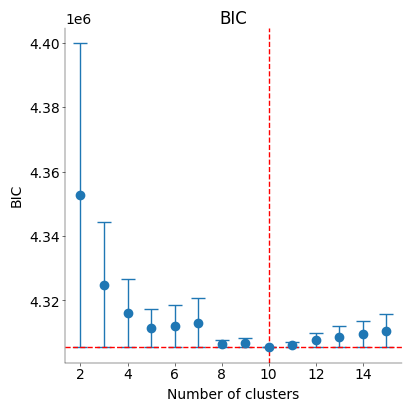

In [77]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot the BIC over number of mixture components and highlight robust estimate and optimal number of clusters (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("BIC")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("BIC")
ax.errorbar(
    all_ks,
    all_bics,
    yerr=all_bics - np.min(all_bics),
    fmt="o",
    capsize=5,
)
ax.axhline(
    best_bic,
    color="red",
    linestyle="--",
    label=f"Best BIC: {best_bic:.2f} (k={best_k})",
)
ax.axvline(
    best_k,
    color="red",
    linestyle="--",
    label=f"Best k: {best_k}",
)
plt.show()

Refit model with lowest BIC and plot data points

In [57]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = 14")
a, m, S, p = fit_mog(b, 14, random_seed=random_seed, init="kmeans")
print(f"lowest BIC: # cluster = 1o")
a, m, S, p = fit_mog(b, 10, random_seed=random_seed, init="kmeans")

# # plot the best model
# fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
# ax.set_title("GMM k = 10")
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_xlim(-5, 10)
# ax.set_ylim(-5, 10)
# ax.set_aspect("equal")
# ax.scatter(b[:, 0], b[:, 1], c=labels, s=5, cmap="viridis", alpha=0.5)
# ax.scatter(
#     means[:, 0],
#     means[:, 1],
#     c="red",
#     s=100,
#     marker="x",
#     label="means",
# )
# ax.legend()
# plt.show()

lowest BIC: # cluster = 14
Iteration 1: Log Likelihood = -2157745.113027
Iteration 2: Log Likelihood = -2151707.304739
Iteration 3: Log Likelihood = -2148676.034329
Iteration 4: Log Likelihood = -2146806.575203
Iteration 5: Log Likelihood = -2145782.958238
Iteration 6: Log Likelihood = -2145190.967541
Iteration 7: Log Likelihood = -2144726.796654
Iteration 8: Log Likelihood = -2144304.951833
Iteration 9: Log Likelihood = -2143917.427439
Iteration 10: Log Likelihood = -2143583.609584
lowest BIC: # cluster = 1o
Iteration 1: Log Likelihood = -2160122.339630
Iteration 2: Log Likelihood = -2154624.702553
Iteration 3: Log Likelihood = -2152070.562038
Iteration 4: Log Likelihood = -2150241.012537
Iteration 5: Log Likelihood = -2148846.830803
Iteration 6: Log Likelihood = -2147760.107866
Iteration 7: Log Likelihood = -2147042.742449
Iteration 8: Log Likelihood = -2146551.198272
Iteration 9: Log Likelihood = -2146171.521802
Iteration 10: Log Likelihood = -2145870.208186


Text(0.5, 0.98, 'Pairwise 1st PCs')

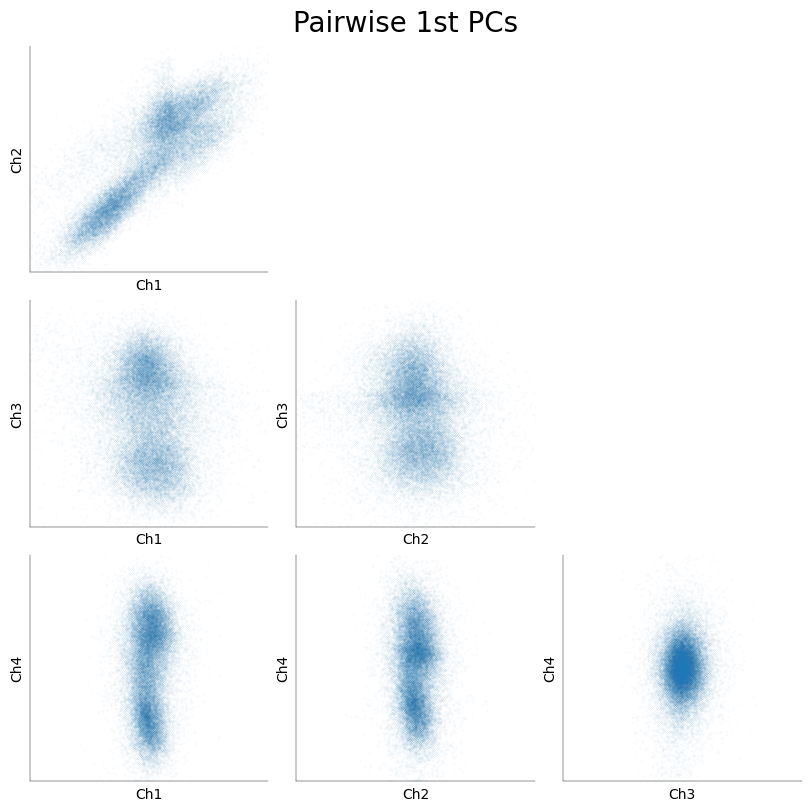

In [54]:
# ------------------------------------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels. (1 pt)
# ------------------------------------------------------------------------------------------------------------------

mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# index of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for mo in np.ravel(mosaic):
    if mo == ".":
        continue
    y, x = mo.split(" vs ")
    ax[mo].scatter(b[:, i[y]], b[:, i[x]], s=0.003, alpha=0.8)

    ax[mo].set_xlabel(x)
    ax[mo].set_ylabel(y)
    ax[mo].set_xlim((-500, 500))
    ax[mo].set_ylim((-500, 500))
    ax[mo].set_xticks([])
    ax[mo].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

## Task 5: Cluster separation and Correlograms

As postprocessing, implement the calculation of auto- and cross correlograms over the spike times.

Plot the (auto-/cross-) correlograms, displaying a time frame of -30ms to +30ms. Choose a good bin size and interprete the resulting diagrams.

_Grading: 3 pts_

#### Hints

_It is faster to calculate the histogram only over the spiketimes that are in the displayed range. Filter the spike times before calculating the histogram!_

_For the autocorrelogram, make sure not to include the time difference between a spike and itself (which would be exactly 0)_

_For the correlogram an efficient implementation is very important - looping over all spike times is not feasible. Instead, make use of numpy vectorization and broadcasting - you can use functions such as tile or repeat._

In [52]:
# ----------------------------------------------------------------------
# Implement a function for calculating the spike time differences (1pt)
# ----------------------------------------------------------------------
def cross_time_diff(spiketimes1: np.ndarray, spiketimes2: np.ndarray) -> np.ndarray:
    """Compute the pairwise time differences between two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster

    Return
    ------

    time_diff: np.ndarray, (n_spikes1, n_spikes2)
        Pairwise time differences between the two sets of spike times
        (i.e., spiketimes1[i] - spiketimes2[j])
    """
    # get the number of spikes in each cluster
    n_spikes1 = spiketimes1.shape[0]
    n_spikes2 = spiketimes2.shape[0]

    # create an empty array to store the time differences
    time_diff = np.zeros((n_spikes1, n_spikes2))

    # compute the pairwise time differences
    for i in range(n_spikes1):
        for j in range(n_spikes2):
            time_diff[i, j] = spiketimes1[i] - spiketimes2[j]

    return time_diff

In [53]:
# -----------------------------------------------------------------------------------
# Calculate and plot auto- and cross correlograms and answer the questions (1+1 pts)
# -----------------------------------------------------------------------------------


def plot_correlograms(
    spiketimes1: np.ndarray,
    spiketimes2: np.ndarray,
    bin_size: float = 0.001,
    max_time: float = 0.5,
) -> tuple[np.ndarray, np.ndarray]:
    """Compute and plot the auto- and cross-correlograms of two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster
    bin_size: float
        Size of the bins for the histogram
    max_time: float
        Maximum time for the histogram

    Returns
    -------
    hist1: np.ndarray, (n_bins, )
        Histogram of the first cluster
    hist2: np.ndarray, (n_bins, )
        Histogram of the second cluster
    """
    # compute the number of bins
    n_bins = int(max_time / bin_size)

    # compute the histograms
    hist1, _ = np.histogram(spiketimes1, bins=n_bins, range=(0, max_time), density=True)
    hist2, _ = np.histogram(spiketimes2, bins=n_bins, range=(0, max_time), density=True)

    # plot the histograms
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
    ax[0].set_title("Auto-correlogram 1")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Rate (Hz)")

### Questions
1) Based on the plot, do you see clusters that contain spikes likely from a single neuron?

_YOUR ANSWER HERE_

2) Do you see cases where plural clusters might come from the same neuron?

_YOUR ANSWER HERE_

3) Do you see clusters that might contain spikes from plural neurons?

_YOUR ANSWER HERE_

4) Explain the term "refractory period" and how one can see it in this plot.

_YOUR ANSWER HERE_